In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader.data as web
from datetime import datetime
from random import sample
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score, KFold
from pandas import *
from sklearn.linear_model import LinearRegression
from scipy import stats
import seaborn as sns
import sys
sys.path.insert(0, '/Users/naftali/air/lawrence')

Using TensorFlow backend.


In [2]:
today = datetime.today().strftime('%Y-%m-%d')
print(today)

extract_sp500_list=False
if extract_sp500_list:
    data    = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    table   = data[0]
    symbols = list(table.Symbol.values)
    print(len(symbols))
    df=pd.DataFrame(symbols)
    os.chdir('/Users/naftali/air/lawrence/')
    df.to_csv('sp500.csv')  
else:
    os.chdir('/Users/naftali/air/lawrence/')
    symbols = pd.read_csv('sp500.csv')
    symbols = list(symbols['0'].values)
    symbols = sorted(symbols)
    print(len(symbols))

2020-07-07
505


In [3]:
extract_sp500_data=False
if extract_sp500_data:
    os.chdir('/Users/naftali/ai_research/markets/data/sp500/')
    j=-1
    start = '1990-01-01';
    end   = '2020-06-01';
    symbols = pd.read_csv('/Users/naftali/air/lawrence/sp500.csv')
    symbols = list(symbols['0'].values)
    symbols = sorted(symbols)
    for i in symbols:
        j+=1
        print(j,i)
        try:
            df = web.DataReader(i,'yahoo', start, end) #.rename(columns={'Adj Close': 'Close'})
            df = df[['Open','High','Low','Close','Adj Close','Volume']]
            df.to_csv('/Users/naftali/air/lawrence/data/' +i+'.csv')
        except KeyError:
            pass

In [5]:
import glob
import pandas as pd

# get data file names
path = '/Users/naftali/air/lawrence/data/'
filenames = glob.glob(path + "*.csv")

dfs = []
for filename in sorted(filenames):
    _=pd.read_csv(filename)
    _['Symbol']=filename.split('/')[-1].split('.')[0]
    _['Date'] = pd.to_datetime(_.Date)
    _ = _.sort_values(by=['Date']).reset_index(drop=True)
    dfs.append(_)

df_concat = pd.concat(dfs, ignore_index=True)
df_concat.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Symbol
0,1999-11-18,32.546494,35.765381,28.612303,31.473534,27.011942,62546300.0,A
1,1999-11-19,30.713520,30.758226,28.478184,28.880543,24.786524,15234100.0,A
2,1999-11-22,29.551144,31.473534,28.657009,31.473534,27.011942,6577800.0,A
3,1999-11-23,30.400572,31.205294,28.612303,28.612303,24.556314,5975600.0,A
4,1999-11-24,28.701717,29.998211,28.612303,29.372318,25.208586,4843200.0,A


In [6]:
bwd_window=50; fwd_window = 20;
#smoothing = 3 
df = df_concat.copy()
df.loc[df.Volume==0,['Open','High','Low','Close','Volume']]=np.nan

df['Open']  = df['Open'] /df['Close']*df['Adj Close']
df['High']  = df['High'] /df['Close']*df['Adj Close']
df['Low']   = df['Low']  /df['Close']*df['Adj Close']
df['Close'] = df['Close']/df['Close']*df['Adj Close']

df = df[['Date','Symbol','Open','High','Low','Close','Volume']]
df.head()

,Date,Symbol,Open,High,Low,Close,Volume
0,1999-11-18,A,27.932802,30.695390,24.556310,27.011942,62546300.0
1,1999-11-19,A,26.359664,26.398033,24.441202,24.786524,15234100.0
2,1999-11-22,A,25.362064,27.011942,24.594679,27.011942,6577800.0
3,1999-11-23,A,26.091084,26.781731,24.556314,24.556314,5975600.0
4,1999-11-24,A,24.633047,25.745754,24.556308,25.208586,4843200.0


In [7]:
for fwd_window in [5,10,20]:
    df['fwd_max_close'] = df.iloc[::-1].groupby('Symbol', sort=False).rolling(fwd_window, on='Close', min_periods=fwd_window).Close.max().iloc[::-1].reset_index(name='field')['field']
    df['fwd_min_close'] = df.iloc[::-1].groupby('Symbol', sort=False).rolling(fwd_window, on='Close', min_periods=fwd_window).Close.min().iloc[::-1].reset_index(name='field')['field']
    df['CPP'+str(fwd_window)] = 100*df['fwd_max_close']/df['Close']-100
    df['CPL'+str(fwd_window)] = 100*df['fwd_min_close']/df['Close']-100
    
    df['fwd_max_high']  = df.iloc[::-1].groupby('Symbol', sort=False).rolling(fwd_window, on='High', min_periods=fwd_window).High.max().iloc[::-1].reset_index(name='field')['field']
    df['fwd_min_low']   = df.iloc[::-1].groupby('Symbol', sort=False).rolling(fwd_window, on='Low',  min_periods=fwd_window).Low.min().iloc[::-1].reset_index(name='field')['field']
    df['PP'+str(fwd_window)] = 100*df['fwd_max_high']/df['Open']-100
    df['PL'+str(fwd_window)] = 100*df['fwd_min_low']/df['Open']-100
    df = df.drop(columns=['fwd_max_close','fwd_min_close','fwd_max_high','fwd_min_low'])

df = df[(df.Date<'2015-01-01')&(df.Date>='1990-01-01')]
df = df[~df.isnull()]
df.head(4)

,Date,Symbol,Open,High,Low,Close,Volume,CPP5,CPL5,PP5,PL5,CPP10,CPL10,PP10,PL10,CPP20,CPL20,PP20,PL20
0,1999-11-18,A,27.932802,30.695390,24.556310,27.011942,62546300.0,0.000000,-9.090896,9.890120,-12.500000,0.284105,-9.090896,9.890120,-12.500000,7.386367,-9.090896,9.890120,-12.500000
1,1999-11-19,A,26.359664,26.398033,24.441202,24.786524,15234100.0,8.978339,-0.928768,2.474531,-7.278021,10.216735,-0.928768,6.404663,-7.278021,17.027879,-0.928768,10.043676,-7.278021
2,1999-11-22,A,25.362064,27.011942,24.594679,27.011942,6577800.0,0.000000,-9.090896,6.505298,-3.177014,3.977274,-9.090896,12.405443,-3.177014,7.386367,-9.090896,14.372170,-3.177014
3,1999-11-23,A,26.091084,26.781731,24.556314,24.556314,5975600.0,5.468737,0.000000,2.647061,-5.882379,14.374984,0.000000,9.264683,-5.882379,18.124986,0.000000,11.176457,-5.882379


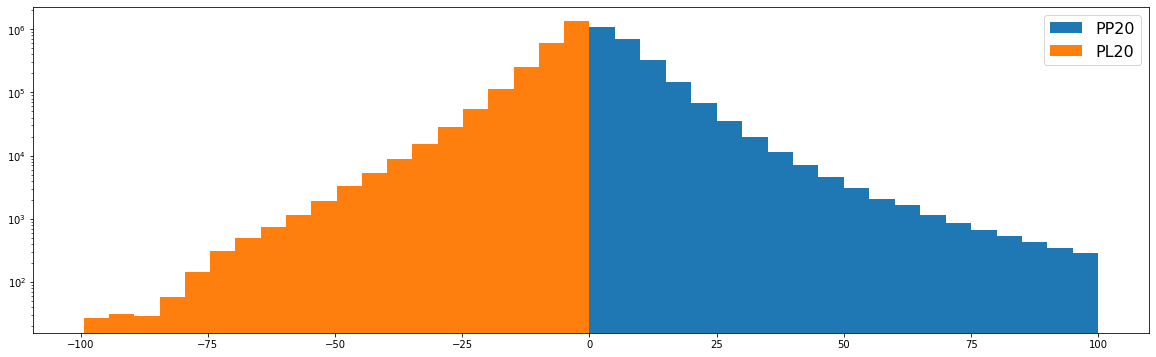

In [8]:
fs=16;
plt.figure(figsize=(20,6))
plt.hist(df.PP20[df.PP20<=100].values,20)
plt.hist(df.PL20[df.PL20<=100].values,20)
plt.yscale('log')
plt.legend(['PP20','PL20'],fontsize=fs)
plt.savefig('pp_pl_hist.png',dpi=100,bbox_inches='tight',pad_inches=.05)
plt.show()

# symmetry of patterns

In [9]:
ind = list(df[(df['CPP20']>=10)&(df['CPP20']<=100)].index)
ind = sample(ind,len(ind))
X_data=[]; y_data=[];
s_num=50000;

for i in ind[:s_num]:
    x = df.loc[i-(bwd_window-1):i,:]['Close'].values
    s = df.loc[i-(bwd_window-1):i,:]['Symbol'].values
    y = df.loc[i-(bwd_window-1):i,:].index.values
    y = y[-1]-y[0]+1
    if np.sum(~np.isnan(x))==bwd_window and y==bwd_window and s[0]==s[-1]:
        X_data.append( (x-np.mean(x))/np.std(x) )
        y_data.append( df.loc[i,:]['CPP20'] )
        
X_data = np.array(X_data)
y_data = np.array(y_data)
print(X_data.shape, y_data.shape)

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
X_data, y_data = shuffle(X_data, y_data, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(48841, 50) (48841,)
(39072, 50) (9769, 50) (39072,) (9769,)


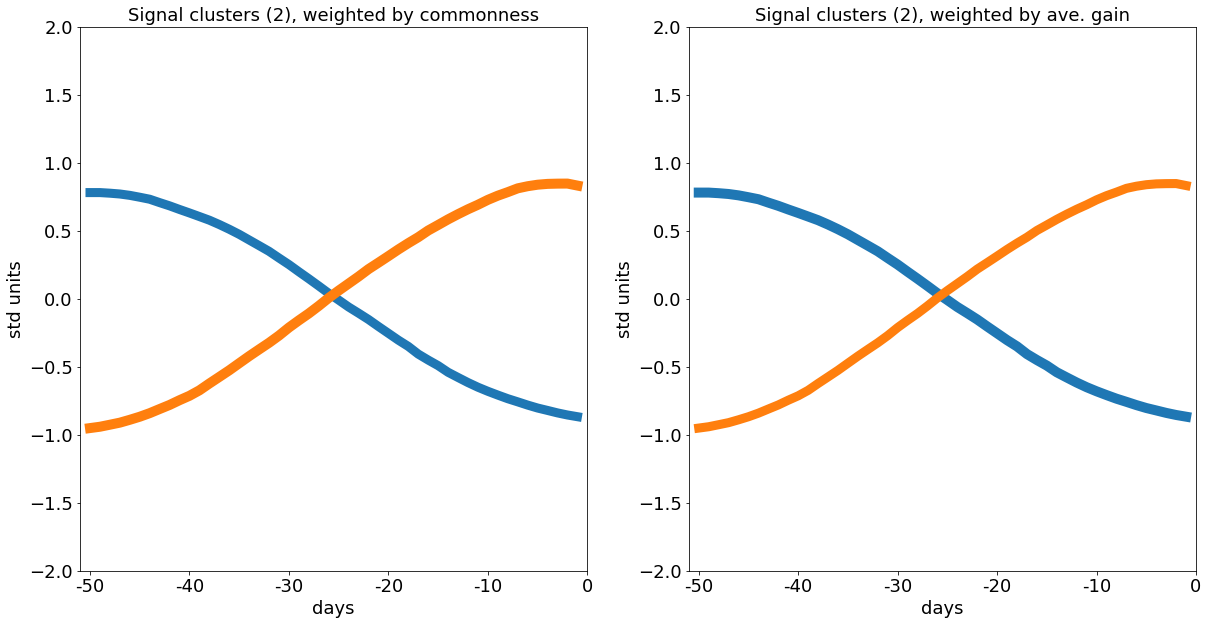

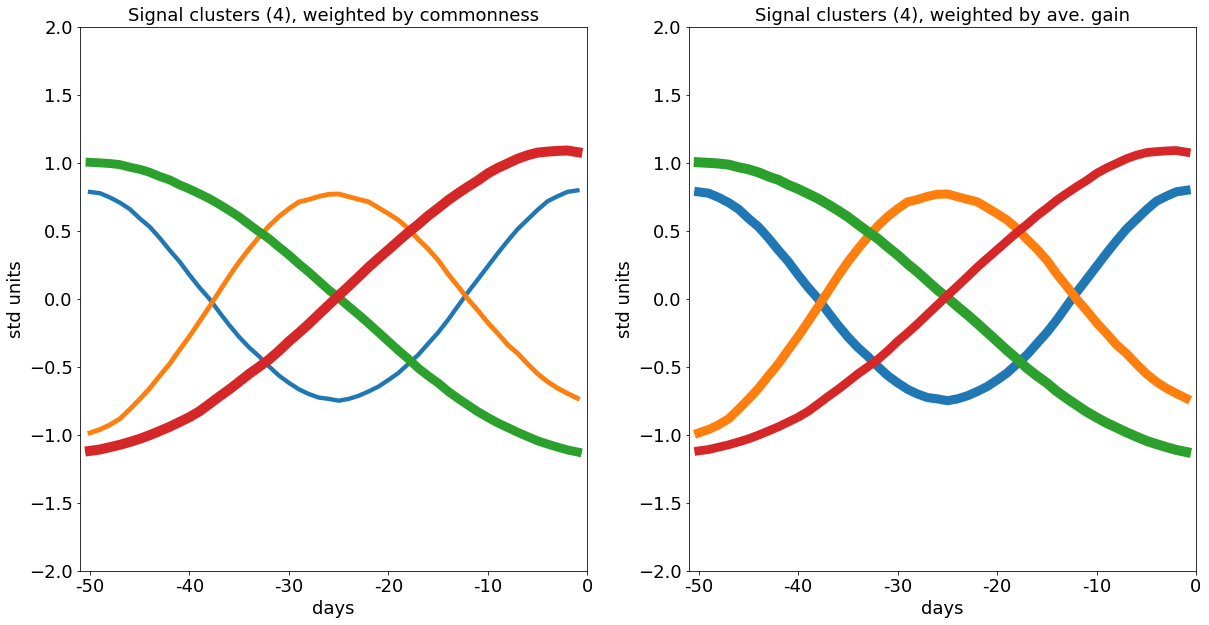

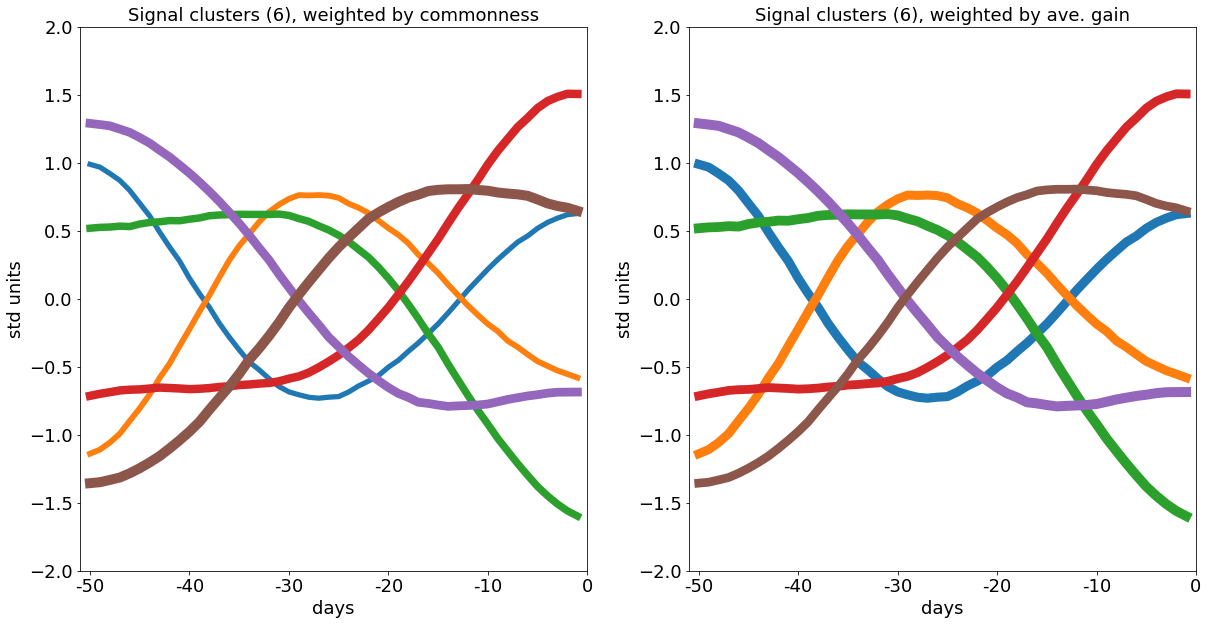

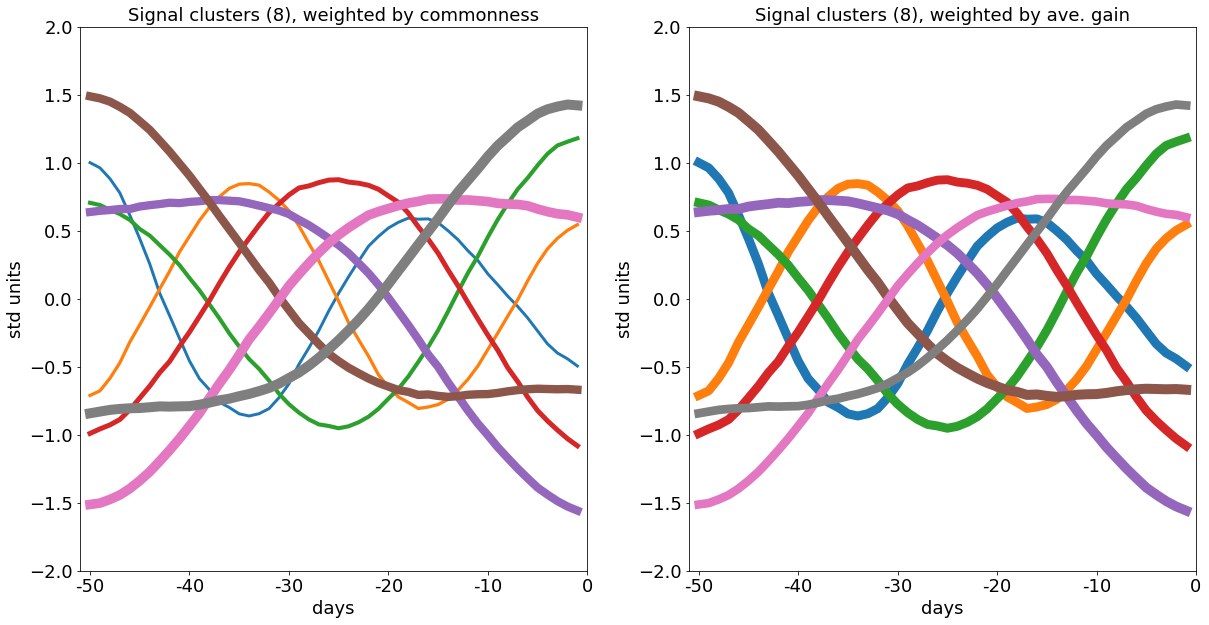

In [10]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.cluster import KMeans, SpectralClustering
cl=['#67001f','#b2182b','#d6604d','#f4a582','#fddbc7','#d1e5f0','#92c5de','#4393c3','#2166ac','#053061']
cl=['#fff7fb','#ece2f0','#d0d1e6','#a6bddb','#67a9cf','#3690c0','#02818a','#016c59','#014636'][::-1]
#https://colorbrewer2.org/#type=sequential&scheme=PuRd&n=9

for n_clusters in [2,4,6,8]:
    clu = KMeans(n_clusters=n_clusters,random_state=0)

    clu.fit( X_data ); labels1 = clu.labels_

    fs=18;
    c=[]
    plt.figure(figsize=(20,10));
    plt.subplot(121)
    w1=[]
    for i in range(n_clusters):
        w1.append( len(X_data[labels1==i])/len(X_data) )
    fact=10/max(w1)
    k=-1
    for i in np.argsort(w1):
        k+=1
        p=plt.plot(np.mean(X_data[labels1==i],0),linewidth=fact*w1[i] )
        c.append(p[0].get_color())
    plt.title('Signal clusters ('+str(n_clusters)+'), weighted by commonness',fontsize=fs)
    plt.ylabel('std units',fontsize=fs);plt.xlabel('days',fontsize=fs)
    plt.xticks(range(0,51,10),range(-50,1,10),fontsize=fs);plt.yticks(fontsize=fs)
    plt.xlim([-1,50]);plt.ylim([-2,2])

    plt.subplot(122)
    w2=[]
    for i in range(n_clusters):
        w2.append( np.mean(y_data[labels1==i]) )
    fact=10/max(w2)
    k=-1
    for i in np.argsort(w1):
        k+=1
        p=plt.plot(np.mean(X_data[labels1==i],0),linewidth=fact*w2[i] )
        c.append(p[0].get_color())
    plt.title('Signal clusters ('+str(n_clusters)+'), weighted by ave. gain',fontsize=fs)
    plt.ylabel('std units',fontsize=fs);plt.xlabel('days',fontsize=fs)
    plt.xticks(range(0,51,10),range(-50,1,10),fontsize=fs);plt.yticks(fontsize=fs)
    plt.xlim([-1,50]);plt.ylim([-2,2])

    plt.savefig('cpp_'+str(n_clusters)+'_clustered_buy_signals.png',dpi=100,bbox_inches='tight',pad_inches=.05)
    plt.show()

/Users/naftali/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Setting whis to 'range' is deprecated since 3.2 and support for it will be removed two minor releases later; set it to [0, 100] to achieve the same effect.
  


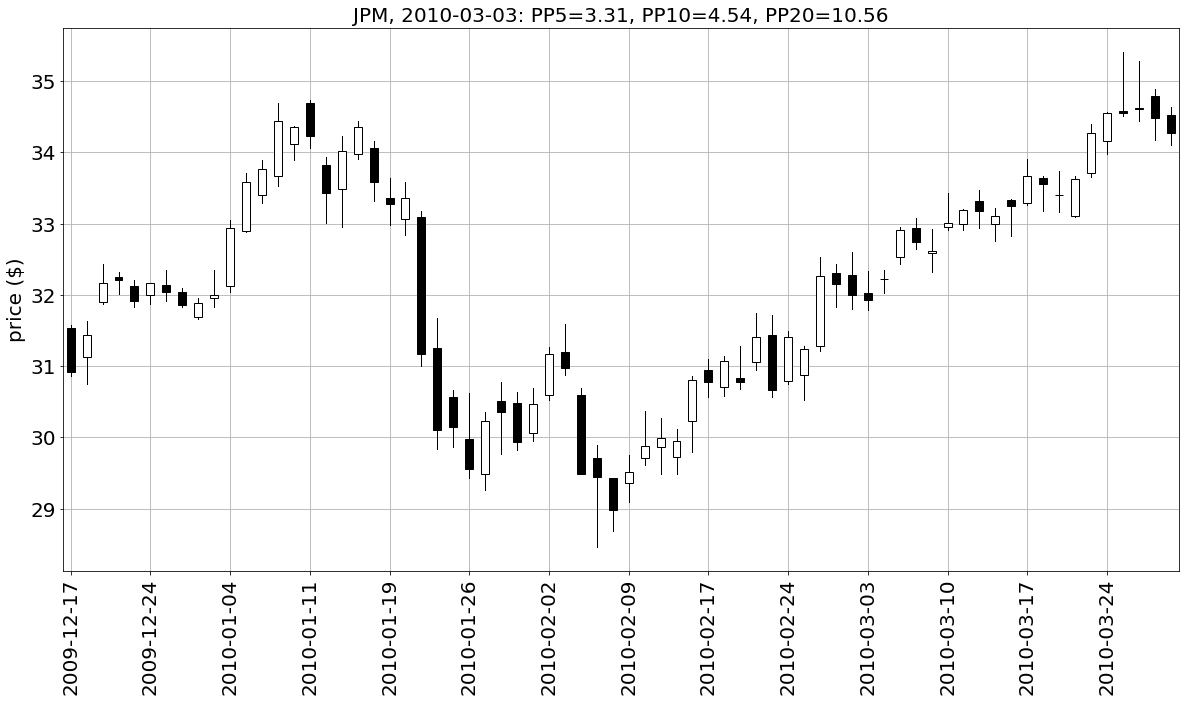

In [11]:
sym = 'JPM'
ind=list(df.loc[(df.loc[:,'Symbol']==sym) & (df.loc[:,'PP20']>10) & (df.loc[:,'Date']>'2010-01-01'),:].index.values)
ind=sample(ind,1)[0]
#ind=1178830
bwd_window=50; fwd_window = 20;
fs=20
a=df.loc[ind-bwd_window:ind+fwd_window-1,:][['Date','Open','Open','Open','High','Low','Close','Close','Close']].reset_index(drop=True)
a.Date=a.Date.astype(str)
data=np.array(a)[:,1:].T
#data=(data-np.min(np.min(data)))/(np.max(np.max(data))-np.min(np.min(data)))
xlabels=np.array(a)[:,0]
plt.figure(figsize=(20,10))
#plt.subplot(3,3,i+1)
bplot=plt.boxplot(data,showfliers=False,showcaps=False,whis='range',medianprops={'linewidth': 0},patch_artist=True,labels=xlabels)
colors=['white' if data[0,i]<data[7,i] else 'black' for i in range(data.shape[1]) ]
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)
#rr=round(df.loc[ind,'RR-5'],2),round(df.loc[ind,'RR-10'],2),round(df.loc[ind,'RR-20'],2)
pp=round(df.loc[ind,'PP5'],2),round(df.loc[ind,'PP10'],2),round(df.loc[ind,'PP20'],2)
d=str(df.loc[ind,'Date']).split(' ')[0]
#ratio=round(len(z_data[y>y_threshold,0][labels==i])/len(z_data[y>y_threshold,0]),2)
title=sym+', '+d+': PP5='+str(pp[0])+', PP10='+str(pp[1])+', PP20='+str(pp[2])
plt.title(title,fontsize=fs)
plt.ylabel('price ($)',fontsize=fs)
plt.xticks(range(1,len(xlabels)+1)[::5],xlabels[::5],fontsize=fs)
plt.xticks(fontsize=fs);plt.yticks(fontsize=fs)
plt.xticks(rotation=90)
plt.grid('on')
plt.savefig('pp_example.png',dpi=100,bbox_inches='tight',pad_inches=.05)
plt.show()

/Users/naftali/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """
/Users/naftali/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """
/Users/naftali/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  
/Users/naftali/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less
  
/Users/naftali/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()
/Users/naftali/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in less
  # This is added back by InteractiveShellApp.init_path()


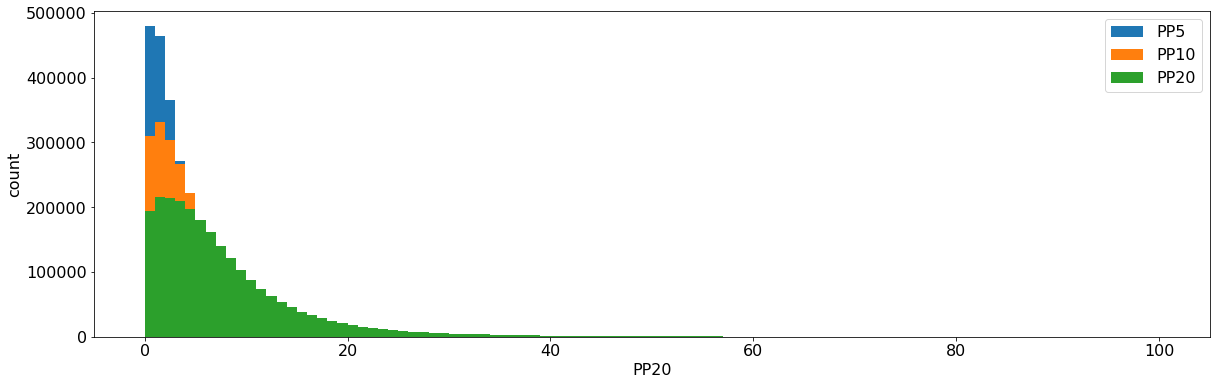

In [12]:
fs=16
plt.figure(figsize=(20,6))

x = df['PP5'].values
x = x[(x>0)&(x<100)]
plt.hist(x,100)
x = df['PP10'].values
x = x[(x>0)&(x<100)]
plt.hist(x,100)
x = df['PP20'].values
x = x[(x>0)&(x<100)]
plt.hist(x,100)
plt.xticks(fontsize=fs);plt.yticks(fontsize=fs);
plt.xlabel('PP20',fontsize=fs)
plt.ylabel('count',fontsize=fs)
plt.legend(['PP5','PP10','PP20'],fontsize=fs)
plt.savefig('pp_hist.png',dpi=100,bbox_inches='tight',pad_inches=.05)
plt.show()